

# 1. Contexto, Objetivos e Perguntas de Pesquisa

-------------------- 


## Contexto
Este projeto analisa um conjunto de dados de avaliações de um aplicativo de gerenciamento de senhas da Google Play Store. O objetivo é utilizar técnicas de Processamento de Linguagem Natural (NLP) modernas para extrair insights profundos sobre a experiência do usuário.

## Objetivo
Utilizar um modelo de Transformer para classificar automaticamente os reviews do Google Play por funcionalidade.
Identificar os pontos fortes e fracos do aplicativo através da análise da média de satisfação de cada categoria.

## Perguntas de Pesquisa
1. **Quais são os Pontos Fortes?** Quais funcionalidades do aplicativo possuem a maior média de satisfação (Rating)?
2. **Quais são os Pontos Críticos (Gargalos)?** Quais funcionalidades estão recebendo as piores avaliações (Notas 1 e 2)?
3. **Validação da Comunidade:** Existe uma correlação positiva entre avaliações com altas notas e o número de curtidas (`thumbs_up`) recebidas?

```

Exemplo previsto para uso do modelo transformer: A frase "Mudei de celular e perdi tudo" é classificada como "Backup" pelo modelo, mesmo sem a palavra backup.O Transformer entende o contexto, diferentemente de buscas simples por palavras-chave.Isso garante que problemas reais e graves sejam detectados corretamente.

## Setup & Preparação

In [88]:
!pip install transformers torch pandas matplotlib seaborn scikit-learn


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [105]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import pipeline
from tqdm import tqdm
import warnings

## Carregar os dados do dataset

Os dados foram obtidos através do dataset do kaggle : https://www.kaggle.com/datasets/muqaddasejaz/google-play-app-reviews-dataset/data

In [90]:
df = pd.read_csv('../data/GooglePlay_App_Data.csv') #le o arquivo
df.head()

,review_id,user_name,review_title,review_description,rating,thumbs_up,review_date,developer_response,developer_response_date,appVersion,laguage_code,country_code
0,81942ead-9d65-4b1a-8aa2-6e21ad5cf5e7,Vernalee Fortin,NaN,"Still loving it!, the best!",5,0,9/3/2024 0:23,NaN,NaN,23.12.04000,en,us
1,c08cf1e7-45e4-43a3-b86f-51f7809b80a3,Toki Doki,NaN,Convenient one stop app for all your passwords...,5,0,8/19/2024 3:32,NaN,NaN,23.12.04000,en,us
2,c8937763-e1b4-43b1-9e48-cde58be80111,CJ Cross,NaN,Tried several password managers until I came a...,5,0,7/30/2024 8:07,NaN,NaN,23.12.04000,en,us
3,762baf4b-9109-4b4b-a42f-2291b0486faf,Trevor Lewis,NaN,Ok thank you,5,0,6/11/2024 17:20,NaN,NaN,NaN,en,us
4,275a2d36-6d77-44ae-9d7b-8be6ad614e3f,K K,NaN,switched phones and none of my passwords came ...,1,0,5/19/2024 19:20,You have to do a backup on Google Drive / Drop...,5/21/2024 23:50,23.12.04000,en,us


In [91]:
df.columns

Index(['review_id', 'user_name', 'review_title', 'review_description',
       'rating', 'thumbs_up', 'review_date', 'developer_response',
       'developer_response_date', 'appVersion', 'laguage_code',
       'country_code'],
      dtype='object')


Vemos que nosso dataset possui várias colunas, cada uma com um papel específico na nossa análise:

*   **Identificação:** `review_id`, `user_name`, `review_title`.
*   **Descrição do review (`review_description`):** Coluna de texto principal, **importante para o Transformer**.
*   **Avaliação (`rating`):** A nota dada pelo usuário, **importante para a análise de correlação**.
*   **Engajamento (`thumbs_up`):** Número de curtidas no review, **importante para saber quantas pessoas concordam com a análise do usuário**.
*   **Cronologia e Suporte:** `review_date` (data do review), `developer_response` (resposta da equipe de desenvolvimento) e `developer_response_date` (**importante para saber a velocidade de resposta da equipe**).
*   **Contexto:** `appVersion` (versão do app), `language_code` (idioma do review) e `country_code` (país do usuário).


In [92]:
df.isna().sum() 

review_id                    0
user_name                    0
review_title               161
review_description           0
rating                       0
thumbs_up                    0
review_date                  0
developer_response         111
developer_response_date    111
appVersion                  15
laguage_code                 0
country_code                 0
dtype: int64

A análise indica ausência de dados em review_title e respostas, mas isso não impacta o projeto pois a coluna essencial review_description está completa. A limpeza é mínima e consiste apenas em preencher os títulos vazios com uma string vazia (''), evitando erros ao processar o texto para o modelo.

Isso deve ser feito pois pretendo unir os titulos com a descrição para facilitar análise do modelo transformer

# 2. Limpeza dos dados

----------

In [93]:
df['review_title']= df['review_title'].replace(np.nan, '') #substitue os dados nulos por uma string vazia
#armazena na coluna orginal, aogra sem dados nulos.
#Replace(Valor_antigo, Valor_Novo)
df.head()

,review_id,user_name,review_title,review_description,rating,thumbs_up,review_date,developer_response,developer_response_date,appVersion,laguage_code,country_code
0,81942ead-9d65-4b1a-8aa2-6e21ad5cf5e7,Vernalee Fortin,,"Still loving it!, the best!",5,0,9/3/2024 0:23,NaN,NaN,23.12.04000,en,us
1,c08cf1e7-45e4-43a3-b86f-51f7809b80a3,Toki Doki,,Convenient one stop app for all your passwords...,5,0,8/19/2024 3:32,NaN,NaN,23.12.04000,en,us
2,c8937763-e1b4-43b1-9e48-cde58be80111,CJ Cross,,Tried several password managers until I came a...,5,0,7/30/2024 8:07,NaN,NaN,23.12.04000,en,us
3,762baf4b-9109-4b4b-a42f-2291b0486faf,Trevor Lewis,,Ok thank you,5,0,6/11/2024 17:20,NaN,NaN,NaN,en,us
4,275a2d36-6d77-44ae-9d7b-8be6ad614e3f,K K,,switched phones and none of my passwords came ...,1,0,5/19/2024 19:20,You have to do a backup on Google Drive / Drop...,5/21/2024 23:50,23.12.04000,en,us


In [94]:
df.isnull().sum()

review_id                    0
user_name                    0
review_title                 0
review_description           0
rating                       0
thumbs_up                    0
review_date                  0
developer_response         111
developer_response_date    111
appVersion                  15
laguage_code                 0
country_code                 0
dtype: int64

- Vemos agora que não possuem dados nulos na coluna de titulo do review

# 3. Análise Exploratória de Dados

------------

## Distribuição de Ratings

- Primeiro vamos analisar a distribuição de Ratings para ver o estado de saúde atual do app. 

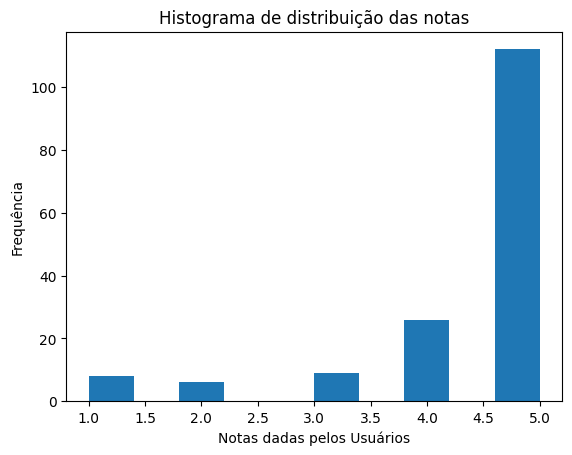

In [95]:
notas_app = df['rating'] #variavel que vai armazenas as notas do aplicativo

plt.hist(notas_app) #plot histograma
plt.xlabel('Notas dadas pelos Usuários')
plt.ylabel('Frequência')
plt.title('Histograma de distribuição das notas')
plt.show()


In [96]:
notas_app.value_counts()

rating
5    112
4     26
3      9
1      8
2      6
Name: count, dtype: int64

O gráfico demonstra uma satisfação extremamente elevada, com a grande maioria das avaliações concentradas na nota máxima (5) e pouquíssimas notas baixas. Isso indica uma aceitação muito positiva por parte dos usuários em relação ao item avaliado. 

Quanto a soma de valores de cada nota vemos que a nota 5 ainda sim é muito superior a nota 4 e demais.

##  Correlação entre Ratings e Números de curtidas por review

Para analisar essa correlação, usarei um scatter plot. O objetivo é verificar se a comunidade concorda com as críticas reportadas. Por exemplo, uma avaliação de 1 estrela com muitas curtidas sugere um bug crítico que afeta diversos usuários. Já se houver poucas curtidas, é provável que seja um erro isolado de apenas um usuário

Text(0.5, 1.0, 'Dispersão: Idade vs Notas')

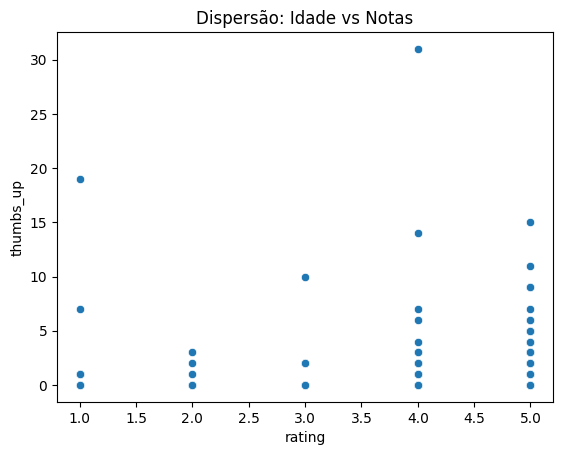

In [97]:
curtidas_review = df['thumbs_up']

sns.scatterplot(data = df, x = notas_app , y= curtidas_review) #eixo x sendo as notas e eixo y sendo as curtidas em review

plt.title("Dispersão: Idade vs Notas")

- A análise do gráfico de dispersão revela que, embora a aplicação seja predominantemente bem avaliada, existem situações específicas de forte concordância da comunidade: destaca-se um ponto isolado na nota mínima (1 estrela) com elevado número de curtidas, sugerindo um bug crítico reportado e confirmado por diversos usuários, enquanto um comentário na nota 4 com engajamento ainda maior aponta para um consenso sobre um feedback relevante ou falha menos severa que, apesar de notável, não compromete a satisfação geral positiva do produto.

## Análise por Versão do App

Identificar versões instáveis com maior incidência de bugs críticos e mapear as atualizações mais estáveis e bem avaliadas pela comunidade.

In [98]:
versoes = df['appVersion']
notas_app.groupby(versoes).mean()#Agrupa as notas_app POR versoes e tire a média

appVersion
10.3.1         5.000000
10.4.1         5.000000
10.5.0         5.000000
10.5.1         5.000000
10.5.3         5.000000
16.0.2         4.650000
17.0.0         4.666667
18.0.0         4.543478
22.11.23001    3.714286
22.12.18000    5.000000
22.12.24000    4.333333
23.02.25000    4.700000
23.08.27000    5.000000
23.09.15000    2.500000
23.12.04000    4.400000
4              4.500000
7.0.0          4.400000
7.0.1          3.400000
7.1.1          4.166667
Name: rating, dtype: float64

Vemos que as versões mais recentes (22 e 23) apresentam menor média de notas, enquanto versões mais antigas e intermediárias, como as da série 10, têm notas excelentes.

## Tamanho do Texto vs. Rating

Esta análise visa entender se existe correlação entre o tamanho do texto e a nota atribuída. A hipótese é que usuários insatisfeitos tendem a escrever comentários mais longos para detalhar problemas, enquanto usuários satisfeitos costumam ser sucintos (ex: 'Muito bom'). Vamos verificar se esse padrão se confirma neste dataset.

In [99]:
df['text_length'] = df['review_description'].astype(str).apply(len) #verifica ot tamanho
#astype(str) serve apenas para prteger se houver algum cmapo vazio ou que nao seja reconhecido como texto seja convertido
df

,review_id,user_name,review_title,review_description,rating,thumbs_up,review_date,developer_response,developer_response_date,appVersion,laguage_code,country_code,text_length
0,81942ead-9d65-4b1a-8aa2-6e21ad5cf5e7,Vernalee Fortin,,"Still loving it!, the best!",5,0,9/3/2024 0:23,NaN,NaN,23.12.04000,en,us,27
1,c08cf1e7-45e4-43a3-b86f-51f7809b80a3,Toki Doki,,Convenient one stop app for all your passwords...,5,0,8/19/2024 3:32,NaN,NaN,23.12.04000,en,us,189
2,c8937763-e1b4-43b1-9e48-cde58be80111,CJ Cross,,Tried several password managers until I came a...,5,0,7/30/2024 8:07,NaN,NaN,23.12.04000,en,us,272
3,762baf4b-9109-4b4b-a42f-2291b0486faf,Trevor Lewis,,Ok thank you,5,0,6/11/2024 17:20,NaN,NaN,NaN,en,us,12
4,275a2d36-6d77-44ae-9d7b-8be6ad614e3f,K K,,switched phones and none of my passwords came ...,1,0,5/19/2024 19:20,You have to do a backup on Google Drive / Drop...,5/21/2024 23:50,23.12.04000,en,us,76
...,...,...,...,...,...,...,...,...,...,...,...,...,...
156,518e0b64-dcfe-4862-814f-319ac079b68e,A Google user,,Simple but effective,5,0,9/12/2016 22:01,NaN,NaN,4,en,us,20
157,5dcd42c0-64a0-4c1c-9d30-0d90845a3705,A Google user,,I like the recognizable icons for identifying ...,4,0,9/10/2016 0:49,NaN,NaN,4,en,us,64
158,ab0b106b-cacb-4e54-9ab8-63cba5d15574,A Google user,,Colorful and pleasing to the eye. Very simple...,5,5,9/4/2016 5:09,NaN,NaN,4,en,us,179
159,1094d763-3d6a-4d53-9ceb-219627306efe,A Google user,,Love it,5,1,9/1/2016 20:45,NaN,NaN,4,en,us,7


Text(0.5, 1.0, 'Boxplot correlação tamanho texto e notas')

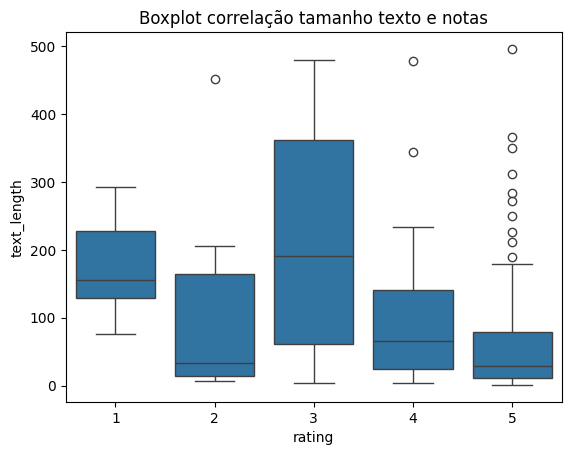

In [100]:
tamanho_texto = df['text_length']
sns.boxplot(data=df, x= notas_app, y=tamanho_texto) #plot boxplot

plt.title('Boxplot correlação tamanho texto e notas')

In [101]:
tamanho_texto.groupby(notas_app).mean() #para ver a media de tamanho de palavras de cada um

rating
1    174.125000
2    123.666667
3    221.666667
4     99.576923
5     64.964286
Name: text_length, dtype: float64

A hipótese foi parcialmente confirmada, pois usuários insatisfeitos (nota 1) escrevem quase o triplo (média 174) dos usuários satisfeitos (nota 5, média 65), provando que a felicidade gera comentários mais diretos. Contudo, o padrão é quebrado pela nota 3, que possui os textos mais longos de todos (221 caracteres), indicando que avaliações neutras exigem mais elaboração para equilibrar prós e contras.

## Evolução das notas com o tempo

Mostra se o app está melhorando ou piorando com o tempo. Você pode ver se houve um "pico de reclamações" em uma data específica (quando um bug foi lançado).

C:\Users\Jonas\AppData\Local\Temp\ipykernel_12228\2227587776.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  media_mensal = df_temporal['rating'].resample('M').mean() #achar a media de nota por mes


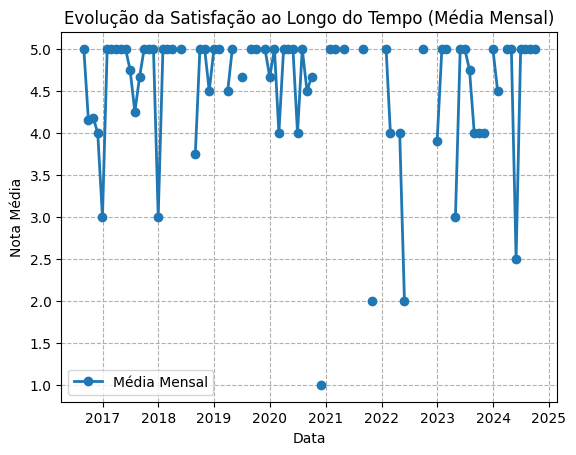

In [102]:
df['review_date'] = pd.to_datetime(df['review_date']) #converte para tipo tempo do pandas as datas
df = df.sort_values('review_date')

df_temporal = df.set_index('review_date')# Definir a data como índice (necessário para o resample)
media_mensal = df_temporal['rating'].resample('M').mean() #achar a media de nota por mes

plt.plot(media_mensal.index, media_mensal.values, marker='o', linewidth=2, markersize=6, color='#1f77b4', label='Média Mensal')

plt.title('Evolução da Satisfação ao Longo do Tempo (Média Mensal)')
plt.xlabel('Data')
plt.ylabel('Nota Média')
plt.grid(True, linestyle='--')
plt.legend()

O gráfico revela uma consistência de excelência (teto de 5 estrelas), interrompida apenas por quedas bruscas que indicam falhas críticas pontuais em datas específicas (prováveis bugs de atualização). No entanto, a recuperação imediata após cada declínio demonstra que a equipe corrige os problemas rapidamente, retornando o app ao patamar máximo de satisfação.

# 4. Criação Features de texto completo

--------

- Aqui criarei nossas features para ajudar na analise do modelo.

In [103]:
df['full_text'] = df['review_title'] + df['review_description'] #texto completo com o titulo mais a descrição
df['full_text_length'] = df['full_text'].apply(len) # pode ser útil para verificações rápidas

df.head()

,review_id,user_name,review_title,review_description,rating,thumbs_up,review_date,developer_response,developer_response_date,appVersion,laguage_code,country_code,text_length,full_text,full_text_length
160,b454b56c-6171-49bb-a04b-b878095b83e2,A Google user,,Awesome,5,1,2016-08-31 06:53:00,NaN,NaN,NaN,en,us,7,Awesome,7
159,1094d763-3d6a-4d53-9ceb-219627306efe,A Google user,,Love it,5,1,2016-09-01 20:45:00,NaN,NaN,4,en,us,7,Love it,7
158,ab0b106b-cacb-4e54-9ab8-63cba5d15574,A Google user,,Colorful and pleasing to the eye. Very simple...,5,5,2016-09-04 05:09:00,NaN,NaN,4,en,us,179,Colorful and pleasing to the eye. Very simple...,179
157,5dcd42c0-64a0-4c1c-9d30-0d90845a3705,A Google user,,I like the recognizable icons for identifying ...,4,0,2016-09-10 00:49:00,NaN,NaN,4,en,us,64,I like the recognizable icons for identifying ...,64
156,518e0b64-dcfe-4862-814f-319ac079b68e,A Google user,,Simple but effective,5,0,2016-09-12 22:01:00,NaN,NaN,4,en,us,20,Simple but effective,20


In [104]:
print("Exemplo de dados pré-processados:")
display(df[['full_text', 'rating']].head(3))

Exemplo de dados pré-processados:


,full_text,rating
160,Awesome,5
159,Love it,5
158,Colorful and pleasing to the eye. Very simple...,5


# 5. Implementando o modelo

-------

- A etapa inicial da implementação consiste na definição das categorias (labels) de classificação. A superioridade do modelo Transformer reside na sua capacidade de interpretar o contexto semântico em vez de apenas buscar palavras-chave. Por exemplo, a frase 'Mudei de celular e perdi tudo' é corretamente classificada como 'Backup', mesmo sem a presença explícita do termo. Isso assegura que problemas críticos sejam detectados com alta precisão.

## Carregamento do modelo

In [108]:
labels = [
    "Backup & Restore", 
    "Interface & Usability", 
    "Security & Login", 
    "Support & Response", 
    "Sync & Cloud", 
    "App Performance"
]

-  Definição do modelo : Estamos instanciando o modelo facebook/bart-large-mnli diretamente da biblioteca Transformers através da função pipeline, que baixa e configura tudo automaticamente para uso imediato. Ele já vem totalmente pré-treinado, permitindo classificar textos em categorias novas (Zero-Shot) sem que você precise ensinar ou treinar nada do zero.

In [107]:
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")

config.json: 0.00B [00:00, ?B/s]

c:\Users\Jonas\AppData\Local\Programs\Python\Python313\Lib\site-packages\huggingface_hub\file_download.py:130: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Jonas\.cache\huggingface\hub\models--facebook--bart-large-mnli. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

Loading weights:   0%|          | 0/515 [00:00<?, ?it/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

![Fluxograma do Modelo](../images/Fluxograma_modelo.jpg)

Abaixo, apresentamos a arquitetura lógica do modelo BART-MNLI, demonstrando como ele transforma frases e labels em previsões de classificação:

![Fluxograma bert](../images/modelo_bert.jpg)

## Função de classificação

In [113]:
def classificar_texto(text):
    result = classifier(text, labels) #entradas do modelo
    return result['labels'][0], result['scores'][0]

## Aplica modelo

In [ ]:
tqdm.pandas() #observar o progresso
#biblitoeca tqdm responsavel por criar barras de progresso
# "injeta" o método progress_apply() no pandas

texto_entrada = df['full_text']
#Aplica classificação na coluna com os textos completos de review
#apartir da função acima irá devolver categoria_classificada (qual label pertece) e tambem a probaibilidade
resultados = texto_entrada.progress_apply(classificar_texto)
#progreess_apply aplica a função em cada linha da coluna 
df['categoria_classificada'] = resultados[0] #nova coluna com a categorias classificadas pelo modelo
df['probabilidade'] = resultados[1] #probabilidade da classificação


  4%|▍         | 7/161 [00:22<07:07,  2.78s/it]

## Visualizar as colunas criadas 

In [ ]:
df[['full_text', 'categoria_classificada', 'probabilidade']].head(10)